# Lesson 1: Timeseries Data and Exoplanets


## Learning Goals: 
- Understand how missions like TESS and Kepler look for repeated changes in brightness to detect planets.
- Learn to plot a light curve using three distinct methods: light curve data, target pixel data, and cutout of an FFI.
- Be familiar with other common uses of timeseries data like stellar astrophysics, asteroseismology, etc.


## How are exoplanets discovered?
### What is a transit? 

<img src="https://upload.wikimedia.org/wikipedia/commons/8/88/Exoplanet_transit_method.gif" width="500">

A transit occurs when a planet passes between a star and its observer. Transits reveal an exoplanet not because we directly see it from many light-years away, but because the planet passing in front of its star ever so slightly dims its light. This dimming can be seen in light curves – graphs showing light received over a period of time. When the exoplanet passes in front of the star, the light curve will show a dip in brightness. A light-curve is a plot of flux vs time, which is the type of plot we will be making today. 

More than just exoplanets, transits can be used to discover and analyze a variety of astronomical systems including binary stars, asteroseismic signals, and much more. We will explore these other applications more in Lesson 2 and beyond. Stay tuned!

## Plotting a Light Curve

We will be exploring the exoplanetary system around the star HD 21749. In 2019, TESS observations lead to the discovery of 2 exoplanets around HD 21749, one of which is Earth sized. HD 21749 is a K-type main sequence star, it has an estimated mass of 0.73 M☉, a radius of 0.70 R☉, and a luminosity of 0.20 L☉.

The inner planet, HD 21749 c, is orbiting at a distance of 0.08 AU with a period of just 7.8 days. It has a radius of 1.1 R🜨 and was the first Earth-sized planet found by TESS. The outer planet, HD 21749 b, orbits the star at a distance of 0.21 AU with a period of 35.6 days. 

The symbol ☉ means "Solar" or "Sun", so M☉ means "Solar Mass". The symbol ⊕ means "Earth", so R🜨 means "Earth Radius".


### Imports

The following cell holds the imported packages. These packages are necessary for running the rest of the cells in this notebook, and you can expect to use some of these packages almost everytime you do astronomical research. A description of each import is as follows:

* `numpy` to handle array mathematics
* `pandas` to handle date conversions
* `fits` from astropy.io for accessing FITS files
* `Table` from astropy.table for creating tidy tables of the data
* `WCS` from astropy.wcs for storing World Coordinate Systems information 
* `SkyCoord` from astropy.coordinates for storing RA and Dec of target 
* `matplotlib.pyplot` for plotting data and images
* `Mast` and `Observations` from astroquery.mast for querying data and observations from the MAST archive
* `Tesscut` from astroquery.mast for cutting out target pixels in FFI

In [2]:
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astroquery.mast import Mast, Observations
from astroquery.mast import Tesscut
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import requests
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Query TESS data from MAST

We will be using the Observations class in the astroquery.mast subpackage from Astroquery. Go back to [Lesson 0](link to lesson 0) if you need more details on querying TESS data. 

This query will return several file types, for more information on TESS file types and data structures, visit the [Data Product Overview Page](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview). 

In [3]:
TESS_table = Observations.query_criteria(objectname="HD 21749", obs_collection="TESS") #dataproduct_type="timeseries"

#Query the observations from MAST to get a list of products for our selected observations
data_products = Observations.get_product_list(TESS_table)

# Get the minimum required products
filtered = Observations.filter_products(data_products, dataproduct_type ='timeseries')

#check out what this filter returned
filtered.show_in_notebook(display_length=10)

idx,obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
0,60834940,TESS,timeseries,tess2018206045859-s0001-0000000279740163-0120-s,Light curves,S,mast:TESS/product/tess2018206045859-s0001-0000000279740163-0120-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,spoc-5.0.10-20200904,N/A,tess2018206045859-s0001-0000000279740163-0120-s_lc.fits,2039040,60834940,PUBLIC,3
1,60834940,TESS,timeseries,tess2018206045859-s0001-0000000279740163-0120-s,Target pixel files,S,mast:TESS/product/tess2018206045859-s0001-0000000279740163-0120-s_tp.fits,SCIENCE,Minimum Recommended Products,TP,--,SPOC,spoc-5.0.10-20200904,N/A,tess2018206045859-s0001-0000000279740163-0120-s_tp.fits,49184640,60834940,PUBLIC,2
2,60842699,TESS,timeseries,tess2018206045859-s0001-0000000279741379-0120-s,full data validation report,S,mast:TESS/product/tess2018206190142-s0001-s0001-0000000279741379-00106_dvr.pdf,INFO,--,DVR,--,SPOC,b11c787608,G011025,tess2018206190142-s0001-s0001-0000000279741379-00106_dvr.pdf,11348388,60842699,PUBLIC,3
3,60842699,TESS,timeseries,tess2018206045859-s0001-0000000279741379-0120-s,full data validation report (xml),S,mast:TESS/product/tess2018206190142-s0001-s0001-0000000279741379-00106_dvr.xml,INFO,--,DVR,--,SPOC,b11c787608,G011025,tess2018206190142-s0001-s0001-0000000279741379-00106_dvr.xml,125181,60842699,PUBLIC,3
4,60842699,TESS,timeseries,tess2018206045859-s0001-0000000279741379-0120-s,full data validation report,S,mast:TESS/product/tess2018206190142-s0001-s0001-0000000279741379-00366_dvr.pdf,INFO,--,DVR,--,SPOC,b11c787608,G011025,tess2018206190142-s0001-s0001-0000000279741379-00366_dvr.pdf,10802523,60842699,PUBLIC,3
5,60842699,TESS,timeseries,tess2018206045859-s0001-0000000279741379-0120-s,full data validation report (xml),S,mast:TESS/product/tess2018206190142-s0001-s0001-0000000279741379-00366_dvr.xml,INFO,--,DVR,--,SPOC,b11c787608,G011025,tess2018206190142-s0001-s0001-0000000279741379-00366_dvr.xml,126551,60842699,PUBLIC,3
6,60842699,TESS,timeseries,tess2018206045859-s0001-0000000279741379-0120-s,Data validation mini report,S,mast:TESS/product/tess2018206190142-s0001-s0001-0000000279741379-00106_dvm.pdf,INFO,Minimum Recommended Products,DVM,--,SPOC,b11c787608,G011025,tess2018206190142-s0001-s0001-0000000279741379-00106_dvm.pdf,2885145,60842699,PUBLIC,3
7,60842699,TESS,timeseries,tess2018206045859-s0001-0000000279741379-0120-s,Data validation mini report,S,mast:TESS/product/tess2018206190142-s0001-s0001-0000000279741379-00366_dvm.pdf,INFO,Minimum Recommended Products,DVM,--,SPOC,b11c787608,G011025,tess2018206190142-s0001-s0001-0000000279741379-00366_dvm.pdf,3740368,60842699,PUBLIC,3
8,60842699,TESS,timeseries,tess2018206045859-s0001-0000000279741379-0120-s,TCE summary report,S,mast:TESS/product/tess2018206190142-s0001-s0001-0000000279741379-01-00106_dvs.pdf,INFO,Minimum Recommended Products,DVS,--,SPOC,b11c787608,G011025,tess2018206190142-s0001-s0001-0000000279741379-01-00106_dvs.pdf,789956,60842699,PUBLIC,3
9,60842699,TESS,timeseries,tess2018206045859-s0001-0000000279741379-0120-s,TCE summary report,S,mast:TESS/product/tess2018206190142-s0001-s0001-0000000279741379-01-00366_dvs.pdf,INFO,Minimum Recommended Products,DVS,--,SPOC,b11c787608,G011025,tess2018206190142-s0001-s0001-0000000279741379-01-00366_dvs.pdf,808551,60842699,PUBLIC,3


<div class="alert-success">
<b> In order to perform data analysis, it is necessary to understand how to parse different columns of a data structure. Use a simple Python code snippet to find how many observations of HD 21749 are time series and how many are FFIs.<b>
</div>

In [4]:
#ANS:
ffi = (data_products['dataproduct_type'] == "image")
print(f"Number of FFIs: {len(data_products[ffi])}")

timeseries = (data_products['dataproduct_type']=='timeseries')
print(f"Number of Time Series: {len(data_products[timeseries])}")

Number of FFIs: 82630
Number of Time Series: 90


We want to plot the light curve for this star using two differnet methods, first to use whats called a Light Curve file and then to use a Target Pixel File. 

A Light Curve file is data that has already been extracted, calibrated, and stored in such a way by MAST such that the user doesn't have to do anything but download the FITS file, this is the simplest way to plot a light curve, but not all targets will have these types of files available. 

A Target Pixel file is data that has been calibrated and stored but has not already had the light curve created within it, so we will perform this process. 

To get the Light Curve file need to choose an observation that is of productType "SCIENCE", of productGroupDescription "Minimum Recommended Product", and of productSubGroupDescription "LC" for Light Curve, so let's take a look at obsID 60842699 which has data that match all these criteria. And, to get the Target Pixel file, we will choose all the same parameters but this time for productSubGroupDescription  we want "TP". 

We do this much parsing in order to download as little data as possible to achieve our light curves. 

In [5]:
filtered_lc = Observations.filter_products(data_products, dataproduct_type ='timeseries', obsID = '60842699',productType = "SCIENCE",productSubGroupDescription = "LC")

#Print out the data products we have filtered for
filtered_lc.show_in_notebook()

idx,obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
0,60842699,TESS,timeseries,tess2018206045859-s0001-0000000279741379-0120-s,Light curves,S,mast:TESS/product/tess2018206045859-s0001-0000000279741379-0120-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,b11c787608,G011025,tess2018206045859-s0001-0000000279741379-0120-s_lc.fits,2039040,60842699,PUBLIC,3


In [6]:
filtered_tp = Observations.filter_products(data_products, dataproduct_type ='timeseries', obsID = '60842699',productType = "SCIENCE",productSubGroupDescription = "TP")

#Print out the data products we have filtered for
filtered_tp.show_in_notebook()

idx,obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
0,60842699,TESS,timeseries,tess2018206045859-s0001-0000000279741379-0120-s,Target pixel files,S,mast:TESS/product/tess2018206045859-s0001-0000000279741379-0120-s_tp.fits,SCIENCE,Minimum Recommended Products,TP,--,SPOC,spoc-5.0.10-20200904,G011025,tess2018206045859-s0001-0000000279741379-0120-s_tp.fits,58017600,60842699,PUBLIC,2


### Download the FITS files

In [7]:
data_lc = Observations.download_products(filtered_lc)
#Take a peek at the FITS file we downloaded
fits_file_lc = data_lc['Local Path'][0]

fits.info(fits_file_lc)
fits_lc = fits.open(fits_file_lc)

data_tp = Observations.download_products(filtered_tp)
#Take a peek at the FITS file we downloaded
fits_file_tp = data_tp['Local Path'][0]

fits.info(fits_file_tp)
fits_tp = fits.open(fits_file_tp)

INFO: Found cached file ./mastDownload/TESS/tess2018206045859-s0001-0000000279741379-0120-s/tess2018206045859-s0001-0000000279741379-0120-s_lc.fits with expected size 2039040. [astroquery.query]
Filename: ./mastDownload/TESS/tess2018206045859-s0001-0000000279741379-0120-s/tess2018206045859-s0001-0000000279741379-0120-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   20076R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 13)   int32   
INFO: Found cached file ./mastDownload/TESS/tess2018206045859-s0001-0000000279741379-0120-s/tess2018206045859-s0001-0000000279741379-0120-s_tp.fits with expected size 58017600. [astroquery.query]
Filename: ./mastDownload/TESS/tess2018206045859-s0001-0000000279741379-0120-s/tess2018206045859-s0001-0000000279741379-0120-s_tp.fits
No.    Name      Ver    Type      Cards   Dim

First, let's examine the contents of the LIGHTCURVE extension of our light curve FITS file, this will hold all the information we need to plot the data. 

In [8]:
lc = fits_lc[1].data
lc.columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

We can see that the LIGHTCURVE extension has columns for TIME and two different fluxes: SAP_FLUX and PDCSAP_FLUX, let's plot both of them and compare. 

<div class="alert-success">
<b> What are the units for FLUX and TIME? <b>
</div>

<div class="alert-danger">
<b> Flux units are e-/s (electrons per second) and Time units are BJD-2457000 (Barycentric Julian Date). <b>
</div>

### Plot the Light Curve

Text(0.5, 0, 'TIME  (BJD-2457000)')

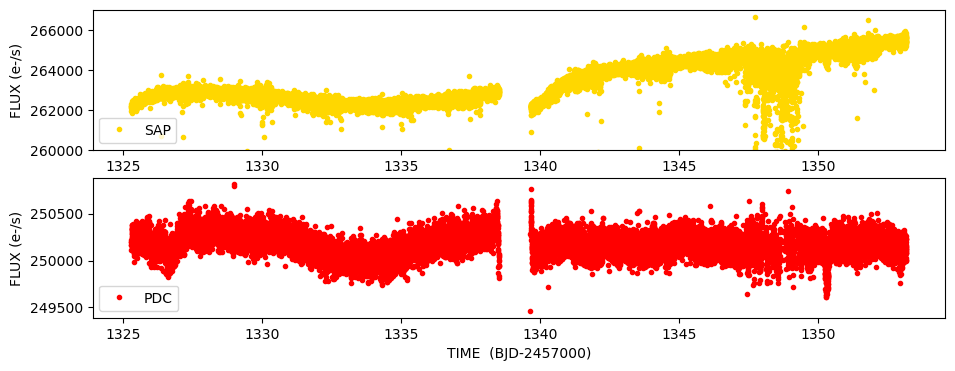

In [9]:
sapflux = lc['SAP_FLUX'] #SAP flux column
pdcflux = lc['PDCSAP_FLUX'] #PDCSAP flux column
time_lc = lc['TIME'] #time column

fig = plt.figure(figsize = (11,4))

fig.add_subplot(211)
plt.plot(time_lc, sapflux,'.', label = 'SAP', color = "gold")
plt.legend(loc = 'lower left')
plt.ylabel("FLUX (e-/s)")
plt.ylim(260000,267000)#zoom in on curve

fig.add_subplot(212)
plt.plot(time_lc, pdcflux,'.', label = 'PDC', color = "red")
plt.legend(loc = 'lower left')
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')

We notice some intersting things about this data immediately. The PDC light curve is created by fitting basis vectors to the time series that are created from all the stars on the same CCD. That fit is used to detrend the SAPFLUX timeseries and create the PDCSAP_FLUX time series. SAP stands for Simple Aperture Photometry, it is the "raw data", meaning it is just a sum of the pixels in the aperture. In this way, those anomalies that are common to all stars are removed. PDC also gaps cadences, which is why many of the highly scattered points are not present in the PDC light curve [(Mullaly, 2018)](https://spacetelescope.github.io/mast_notebooks/notebooks/TESS/beginner_tesscut_astroquery/beginner_tesscut_astroquery.html#create-a-light-curve-from-the-cutout). 

### Getting a Light Curve from the Target Pixel File

Now, we will use the other FITS file we have downloaded to extract the light curve from the pixels. Aftwards, we can compare these two light curves. 

Let's start by examining the contents of our Target Pixel FITS file. 

In [10]:
fits.info(fits_file_tp)

Filename: ./mastDownload/TESS/tess2018206045859-s0001-0000000279741379-0120-s/tess2018206045859-s0001-0000000279741379-0120-s_tp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  PIXELS        1 BinTableHDU    248   20076R x 11C   [D, E, J, 143J, 143E, 143E, 143E, 143E, J, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 13)   int32   
  3  TARGET COSMIC RAY    1 BinTableHDU     27   0R x 4C   [J, I, I, E]   


#### Determining the Optimal Aperture from the PIXELS extension
Each pixel in the aperture extension image is an integer that represents a set of binary flags. The entire set of flags and what they mean can be found in the TESS Archive Manual. Of interest to us in this exersize is which pixels belong to the "optimal aperture" used to create this target's light curve. (Mullaly 2018)

In [11]:
aperture_image = fits_tp[2].data
aperture = np.bitwise_and(aperture_image, 2) / float(2)
aperture

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

<div class="alert-success">
    <b>How many pixels are in our optimal aperture?</b>
</div>

In [12]:
#ANS:
print(np.sum(aperture))

24.0


### Get the Flux and Time for the Optimal Aperture
We can see that there are some values of "1" in our optimal aperture array, these indicate the pixels that we will use to create the target's light curve. Now, to create a time series we need to sum the FLUX values for each of the pixels in the optimal aperture. 

In [13]:
#This is a basic function for getting the aperture photometry
def aperture_phot(image,aperture):
    flux = np.sum(image[aperture==1])
    return flux

In [14]:
#get the data for the PIXELS extension of our fits file
pix = fits_tp[1].data

#Use the map lambda function to sum all the flux in each pixel in our defined aperture
flux = np.array(list (map (lambda x: aperture_phot(x,aperture), pix['FLUX'])))

#get the time from the PIXELS extension of our fits file
time = pix["TIME"]

### Plot the Light Curve


(260000.0, 266500.0)

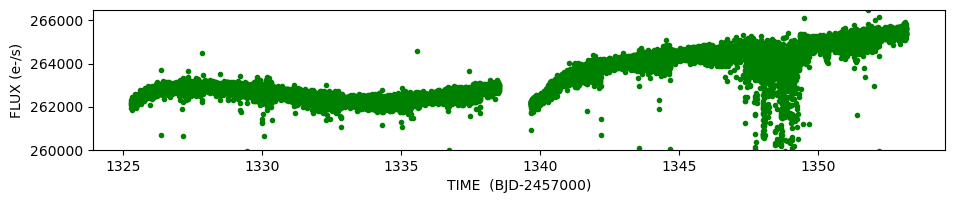

In [15]:
fig = plt.figure(figsize = (11,4))
fig.add_subplot(212)
plt.plot(time, flux,'.', color = "green")
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')
plt.ylim(260000,266500) #zoom in on curve

### Compare Light Curves
Now that we have a SAP_FLUX light curve and and the light curve we calculated with the target pixel files, we can overplot them.

(260000.0, 266500.0)

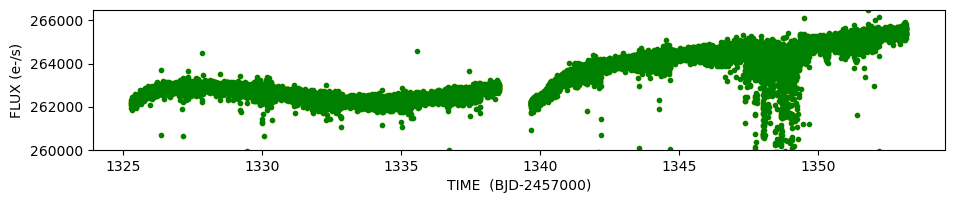

In [16]:
fig = plt.figure(figsize = (11,4))
fig.add_subplot(211)
plt.plot(time_lc, sapflux, ".", color = "gold")
plt.plot(time, flux,'.', color = "green")
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')
plt.ylim(260000,266500) #zoom in on curve

Success! The light curve that we calculated from our Target Pixel file is exactly the same as the SAP_FLUX light curve we got from the Light Curve file. 

<div class="alert-success">
    <b>Plot the difference between the SAP flux and the flux we calculated from the Target Pixel File.</b>
</div>

Text(0.5, 0, 'TIME  (BJD-2457000)')

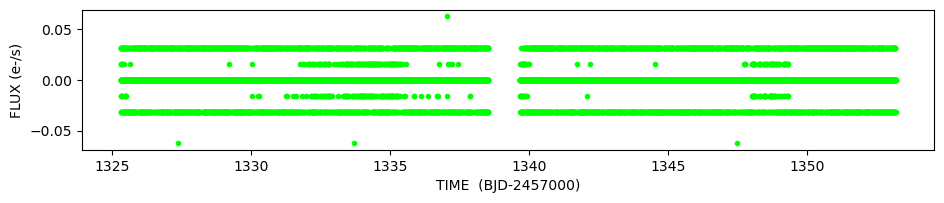

In [17]:
#make everyone a float
sapflux_float = []
for val in sapflux:
     sapflux_float.append(float(val))
sapflux_float = np.array(sapflux_float)
flux_float = []
for val in flux:
     flux_float.append(float(val))
flux_float = np.array(flux_float)
#ANS: 
fig = plt.figure(figsize = (11,4))
fig.add_subplot(212)
plt.plot(time_lc, sapflux_float-flux_float, ".", color = "lime")
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')

<div class="alert-danger">
    NOTE: I tried to fix this difference but was unable to, please advise!
</div>

## Create a Light Curve from an FFI
Lastly, we will explore how to get a light curve by cutting out an FFI (Full Frame Image). This time, we will be using observations of a known exoplanetary system around the star, HD10180. 



In [18]:
TESS_table = Observations.query_criteria(objectname="HD10180", obs_collection="TESS")

TESS_table

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str4,str4,str10,str4,str4,str7,str9,str1,str47,float64,float64,str10,str14,int64,float64,float64,float64,float64,float64,str1,float64,str34,str1,int64,str134,str1,str73,str6,bool,float64,str8,str9,str9,float64
science,TESS,SPOC,Photometer,TESS,TESS,Optical,231836967,--,tess2020212050318-s0028-0000000231836967-0190-s,24.5047183935044,-60.4988955431953,timeseries,"Ricker, George",3,59061.35180872,59086.59940425,120.0,600.0,1000.0,--,59121.0,G03274,--,28,CIRCLE ICRS 24.50471839 -60.49889554 0.00138889,--,mast:TESS/product/tess2020212050318-s0028-0000000231836967-0190-s_lc.fits,PUBLIC,False,nan,27831588,71240768,71240768,66.97815980348409
science,TESS,SPOC,Photometer,TESS,TESS,Optical,231836962,--,tess2020212050318-s0028-0000000231836962-0190-s,24.4732390487091,-60.5115237328827,timeseries,"Ricker, George",3,59061.35181036,59086.59940508,120.0,600.0,1000.0,--,59121.0,G03272_G03227_G03182_G03106_G03251,--,28,CIRCLE ICRS 24.47323905 -60.51152373 0.00138889,--,mast:TESS/product/tess2020212050318-s0028-0000000231836962-0190-s_lc.fits,PUBLIC,False,nan,27831594,71240780,71240780,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0028-3-1,15.754015091277976,-62.01508656186368,image,"Ricker, George",3,59061.34940418,59086.59964486,475.199791,600.0,1000.0,--,59121.0,N/A,--,28,POLYGON 12.42318400 -54.05808100 31.54794300 -58.61444800 21.74082900 -70.11356600 357.40047300 -62.96498400 12.42318400 -54.05808100,--,--,PUBLIC,False,nan,27844462,71266503,71266503,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,231836962,--,tess2020238165205-s0029-0000000231836962-0193-s,24.4732390487091,-60.5115237328827,timeseries,"Ricker, George",3,59087.74108219,59113.93536632,120.0,600.0,1000.0,--,59158.0,G03272_G03227_G03182_G03106_G03251,--,29,CIRCLE ICRS 24.47323905 -60.51152373 0.00138889,--,mast:TESS/product/tess2020238165205-s0029-0000000231836962-0193-s_lc.fits,PUBLIC,False,nan,27908998,71395567,71395567,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,231836967,--,tess2020238165205-s0029-0000000231836967-0193-s,24.5047183935044,-60.4988955431953,timeseries,"Ricker, George",3,59087.7410814,59113.93536654,120.0,600.0,1000.0,--,59158.0,G03274,--,29,CIRCLE ICRS 24.50471839 -60.49889554 0.00138889,--,mast:TESS/product/tess2020238165205-s0029-0000000231836967-0193-s_lc.fits,PUBLIC,False,nan,27908999,71395569,71395569,66.97815980348409
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0029-3-2,17.08836612681128,-61.34193195889686,image,"Ricker, George",3,59087.74547903,59113.93266689,475.199793,600.0,1000.0,--,59158.0,N/A,--,29,POLYGON 18.79523600 -52.89103500 34.68504700 -61.14795700 13.28748200 -69.70152900 1.00579700 -59.43834400 18.79523600 -52.89103500,--,--,PUBLIC,False,nan,27972863,71523282,71523282,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,231836962,--,tess2018206045859-s0001-0000000231836962-0120-s,24.4732390487091,-60.5115237328827,timeseries,"Ricker, George",3,58324.79503361111,58352.67887930555,120.0,600.0,1000.0,--,58458.5833333,G011183_G011025_G011048_G011250,--,1,CIRCLE 24.47323905 -60.51152373 0.00138889,--,mast:TESS/product/tess2018206045859-s0001-0000000231836962-0120-s_lc.fits,PUBLIC,False,nan,60844208,109585835,109585835,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,231836962,--,tess2018234235059-s0002-0000000231836962-0121-s,24.4732390487091,-60.5115237328827,timeseries,"Ricker, George",3,58353.60944230324,58381.01629024305,120.0,600.0,1000.0,--,58458.5833333,G011183_G011025_G011048_G011250,--,2,CIRCLE 24.47323905 -60.51152373 0.00138889,--,mast:TESS/product/tess2018234235059-s0002-0000000231836962-0121-s_lc.fits,PUBLIC,Fal

We can see that there are four FFI's for HD10180 in the TESS database. Great!

### Use Astrocut to get pixel timeseries cutout from TESS FFIs

Now, we have to use the package Astrocut to cut out the pixels in our FFI around our target's coordinates. This will give us am HDUlist. HDUlist objects are the same thing you get back as if you downloaded a fits file and then run the following code on the file: hdu =  astropy.io.fits.open(FITS_file_name), which is what we did earlier. 

The format of the data now is exactly the same as a Target Pixel File, we will perform much of the same steps as before to plot the light curve now. 


In [19]:
hdulist = Tesscut.get_cutouts(objectname = "HD10180", size=20)

In [20]:
hdulist[0].info()
hdu1 = hdulist[0]

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   ()      
  1  PIXELS        1 BinTableHDU    281   1282R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        82   (20, 20)   int32   


Now, we will follow the same steps as earlier for using a Target Pixel File to plot a light curve. This will utilize the function we defined earlier `aperture_phot`. However, this time we will be using all the pixels in the cutout instead of finding an Optimal Aperture. To use all the returned pixels, we set our 2D aperture array to be True for all those with a value of 1 in that image. 

In [21]:
# Use all pixels in our aperture
aperture_ffi = hdu1[2].data == 1

#get the data for the PIXELS extension of our fits file
pix_ffi = hdu1[1].data

#Use the map lambda function to sum all the flux in each pixel in our defined aperture
flux_ffi = np.array(list (map (lambda x: aperture_phot(x, aperture_ffi), pix_ffi['FLUX'])))
#get the time array
time_ffi = hdu1[1].data['TIME']

<div class="alert-success">
    <b>How many pixels are in the cutout aperture?</b>
</div>

In [22]:
#ANS:
print(np.sum(aperture_ffi))

400


### Plot the Light Curve

(1340.0, 1350.0)

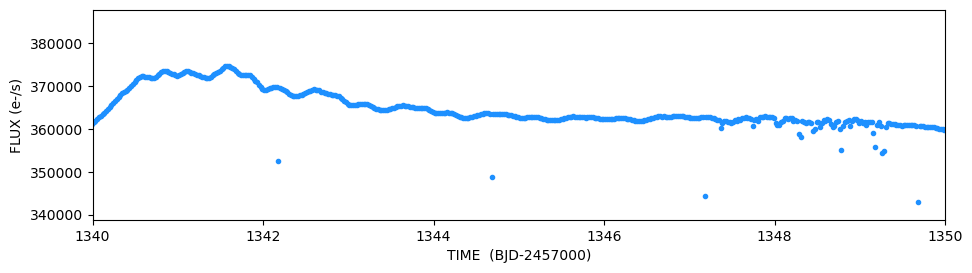

In [23]:
fig = plt.figure(figsize = (11,6))
fig.add_subplot(212)
plt.plot(time_ffi, flux_ffi,'.', color = "dodgerblue")
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')
plt.xlim(1340,1350) #zoom in
# plt.ylim(350000,370000) #zoom in 

<div class="alert-success">
    <b>How many dips in the light curve can you see?</b>
</div>

ANS: 7

## Homework
Geometry puzzle. Assume a normal distribution of orbital inclinations. What fraction of planets with radius RE would we observe fully transiting the disk of their sun-like (R = R☉) host stars? Related further reading on transit geometry.

## Additional Resources
Can't get enough? Here are some links to more information!

Here is the paper which announced TESS's [discovery of the exoplanets around HD 21749](https://iopscience.iop.org/article/10.3847/2041-8213/ab12ed/meta). 

Here is a link to the [SIMBAD page](https://simbad.u-strasbg.fr/simbad/sim-id?Ident=HD10180&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id) on HD10180.

## Whats next?
You may have noticed that there is some messy signal in our light curves, next week we will learn what a data quality flag is and how to remove data corresponding to bad data quality flags in order to clean up our plots. Additonally, we will start to look into other types of systems that can be identified using the transit method/light curves. 

## Acknowledgements

This notebook includes data collected with the TESS mission, obtained from the MAST data archive at the Space Telescope Science Institute (STScI). Funding for the TESS mission is provided by the NASA Explorer Program. STScI is operated by the Association of Universities for Research in Astronomy, Inc., under NASA contract NAS 5–26555.

Any published work that uses Astroquery should include a citation which can be found at [this link](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION) or the BibTeX entry is available from the package itself with: `astroquery.__citation__`

### Notebook Information:
Author: Emma Lieb

Last Updated: 07/05/2023